# Teste dos Modelos sem Ajuste

In [45]:
import torch
import torch.nn as nn
import torchvision
import torchinfo
import numpy as np
import sys
import os

from pathlib import Path

sys.path.insert(0, os.path.abspath('src'))

import src.vcpi_util as vcpi_util
from src.constants import device, BATCH_SIZE, WORKERS, PREFETCH, EPOCHS
from src.models import ModernCNN, ImprovedCNN, EfficientCNN, AttentionCNN, train_model, evaluate_model

In [46]:
PATH_TRAINING_SET = Path("data/train_images").resolve()
PATH_TEST_SET = Path("data/test_images").resolve()

As transformações não são utilizadas neste contexto para testar a eficácia isolada do modelo.

Apenas o redimensionamento é aplicado uma vez que o modelo exige uma entrada de tamanho fixo.

In [47]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((32,32)), torchvision.transforms.ToTensor()])

In [48]:
train_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = transform)
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=WORKERS,
    pin_memory=True,
    prefetch_factor=PREFETCH,
    persistent_workers=True)


test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = transform)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    num_workers=WORKERS,
    pin_memory=True,
    prefetch_factor=PREFETCH,
    persistent_workers=True)

In [49]:
def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


def show_bad_preds(model, dataset, classes):
    k = 0
    iters = 0

    preds = []
    ground_truth = []
    imgs = torch.Tensor(52, 3, 128,128)

    iterator = iter(dataset)

    max_iters = test_set.__len__() / BATCH_SIZE
    while k < 52 and iters < max_iters:

        images, targets = next(iterator)
        #print(images[0].shape)
        logits = model(images.to(device))
        
        #print(predictions[0])
        predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
        for i in range(len(predictions)):

            if np.argmax(predictions[i]) != targets[i] and k < 52:

                preds.append(predictions[i])
                ground_truth.append(targets[i])
                imgs[k, :, :, :] = inverse_normalize(images[i],[3, 128, 128], [0.229, 0.224, 0.225])
                k += 1

        iters += 1

    vcpi_util.plot_predictions(imgs, preds, ground_truth, classes, 13, 4)     

In [50]:
def model_info(model, train_loader, train_set, test_loader, EPOCHS, name="AttentionCNN"):
    model.to(device)

    torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 32, 32))

    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = torch.nn.CrossEntropyLoss()

    history = train_model(model, train_loader, test_loader, EPOCHS, loss_fn, optimizer)

    best_train = np.asarray(history['train_acc']).argmax()
    best_test = np.asarray(history['val_acc']).argmax()

    print('Best epoch for train accuracy: :', best_train,' Best epoch for test accuracy: :',  best_test)
    print('Test accuracy at epoch ',best_train, ' :', history['train_acc'][best_train], 'Test accuracy at epoch ',best_test, ' :', history['train_acc'][best_test])
    preds = []
    ground_truth = []

    for images, targets in test_loader:

        logits = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in logits.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds, len(train_set.class_to_idx))

    evaluate_model(model, test_loader)

    vcpi_util.show_history_plus(history, ['train_acc', 'val_acc'])

# Modelo Attention




------------------------------ Epoch 1/20 ------------------------------
Total time: 40.43s
Train Loss: 1.6645 Train Acc: 49.80%
Val Loss: 0.5344 Val Acc: 84.66%

------------------------------ Epoch 2/20 ------------------------------
Total time: 31.69s
Train Loss: 0.3055 Train Acc: 90.79%
Val Loss: 0.2770 Val Acc: 92.32%

------------------------------ Epoch 3/20 ------------------------------
Total time: 34.37s
Train Loss: 0.1387 Train Acc: 95.94%
Val Loss: 0.2229 Val Acc: 93.31%

------------------------------ Epoch 4/20 ------------------------------
Total time: 36.15s
Train Loss: 0.0923 Train Acc: 97.21%
Val Loss: 0.1491 Val Acc: 95.46%

------------------------------ Epoch 5/20 ------------------------------
Total time: 33.63s
Train Loss: 0.0676 Train Acc: 97.99%
Val Loss: 0.1679 Val Acc: 95.55%

------------------------------ Epoch 6/20 ------------------------------
Total time: 35.01s
Train Loss: 0.0570 Train Acc: 98.31%
Val Loss: 0.0971 Val Acc: 97.25%

---------------------

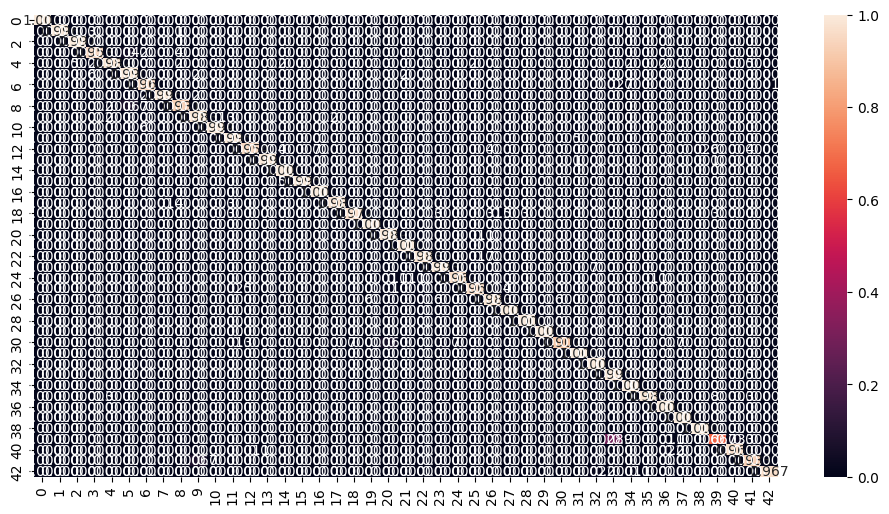

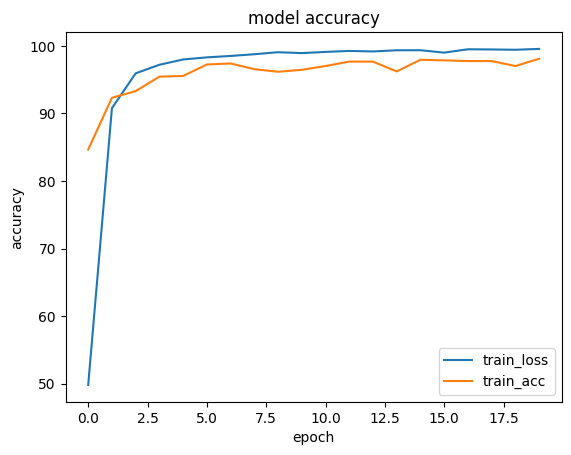

In [51]:
model = AttentionCNN(len(train_set.classes))

model_info(model, train_loader, train_set, test_loader, EPOCHS, name="AttentionCNN")

# Modelo Modern


------------------------------ Epoch 1/20 ------------------------------
Total time: 31.44s
Train Loss: 0.6683 Train Acc: 80.37%
Val Loss: 0.1362 Val Acc: 96.37%

------------------------------ Epoch 2/20 ------------------------------
Total time: 29.98s
Train Loss: 0.1258 Train Acc: 96.19%
Val Loss: 0.1234 Val Acc: 96.77%

------------------------------ Epoch 3/20 ------------------------------
Total time: 28.85s
Train Loss: 0.0878 Train Acc: 97.42%
Val Loss: 0.1110 Val Acc: 97.04%

------------------------------ Epoch 4/20 ------------------------------
Total time: 33.03s
Train Loss: 0.0698 Train Acc: 97.72%
Val Loss: 0.1122 Val Acc: 97.24%

------------------------------ Epoch 5/20 ------------------------------
Total time: 28.91s
Train Loss: 0.0572 Train Acc: 98.28%
Val Loss: 0.0906 Val Acc: 97.44%

------------------------------ Epoch 6/20 ------------------------------
Total time: 30.01s
Train Loss: 0.0472 Train Acc: 98.56%
Val Loss: 0.0737 Val Acc: 97.90%

---------------------

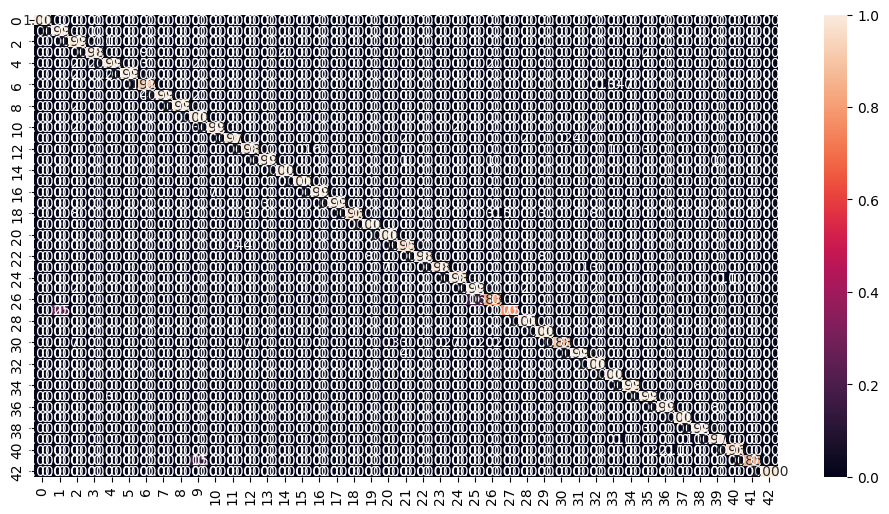

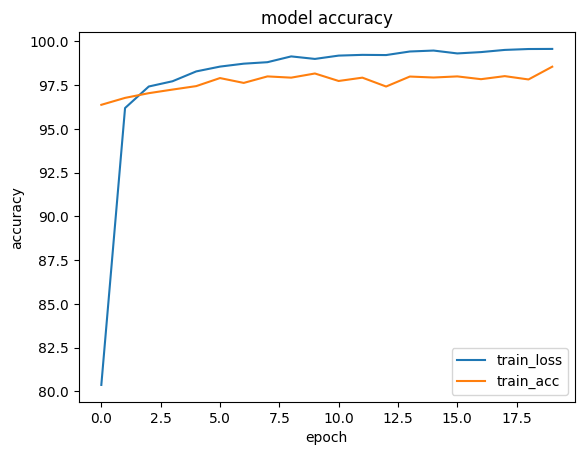

In [52]:
model = ModernCNN(len(train_set.classes))
model.to(device)

model_info(model, train_loader, train_set, test_loader, EPOCHS, name="ModernCNN")

# Modelo Improved


------------------------------ Epoch 1/20 ------------------------------
Total time: 31.73s
Train Loss: 1.4450 Train Acc: 55.03%
Val Loss: 0.5807 Val Acc: 82.13%

------------------------------ Epoch 2/20 ------------------------------
Total time: 34.27s
Train Loss: 0.2962 Train Acc: 90.52%
Val Loss: 0.4960 Val Acc: 86.60%

------------------------------ Epoch 3/20 ------------------------------
Total time: 30.50s
Train Loss: 0.1559 Train Acc: 95.28%
Val Loss: 0.3440 Val Acc: 90.91%

------------------------------ Epoch 4/20 ------------------------------
Total time: 31.87s
Train Loss: 0.1079 Train Acc: 96.76%
Val Loss: 0.3231 Val Acc: 91.58%

------------------------------ Epoch 5/20 ------------------------------
Total time: 33.94s
Train Loss: 0.0835 Train Acc: 97.69%
Val Loss: 0.2900 Val Acc: 92.81%

------------------------------ Epoch 6/20 ------------------------------
Total time: 35.59s
Train Loss: 0.0732 Train Acc: 97.84%
Val Loss: 0.3611 Val Acc: 90.95%

---------------------

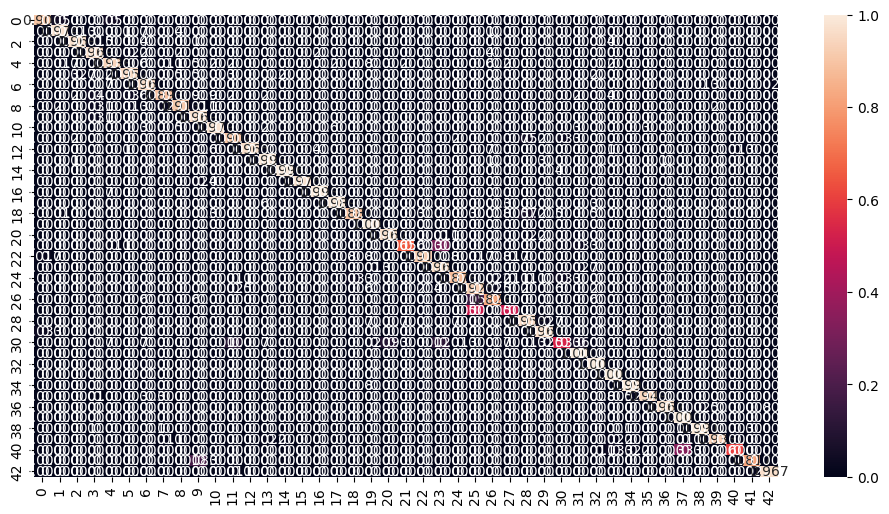

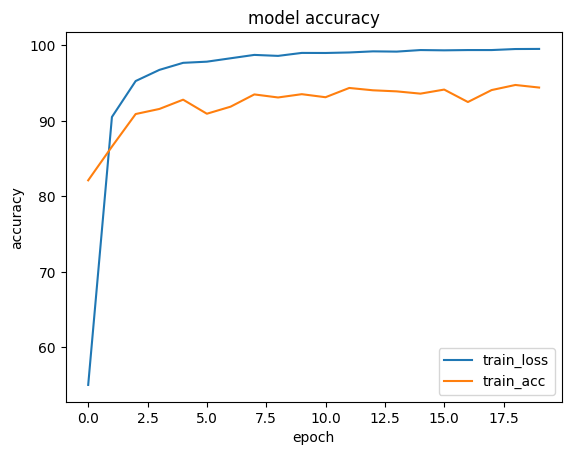

In [53]:
model = ImprovedCNN(len(train_set.classes))
model.to(device)

model_info(model, train_loader, train_set, test_loader, EPOCHS, name="ImprovedCNN")

# Modelo Efficient


------------------------------ Epoch 1/20 ------------------------------
Total time: 47.68s
Train Loss: 0.9389 Train Acc: 72.12%
Val Loss: 0.5508 Val Acc: 83.75%

------------------------------ Epoch 2/20 ------------------------------
Total time: 55.44s
Train Loss: 0.1937 Train Acc: 93.98%
Val Loss: 0.5081 Val Acc: 85.89%

------------------------------ Epoch 3/20 ------------------------------
Total time: 50.34s
Train Loss: 0.1194 Train Acc: 96.29%
Val Loss: 0.4664 Val Acc: 88.12%

------------------------------ Epoch 4/20 ------------------------------
Total time: 61.23s
Train Loss: 0.0910 Train Acc: 97.16%
Val Loss: 0.3793 Val Acc: 90.67%

------------------------------ Epoch 5/20 ------------------------------
Total time: 48.07s
Train Loss: 0.0669 Train Acc: 97.83%
Val Loss: 0.4049 Val Acc: 89.83%

------------------------------ Epoch 6/20 ------------------------------
Total time: 39.06s
Train Loss: 0.0674 Train Acc: 97.84%
Val Loss: 0.3206 Val Acc: 92.06%

---------------------

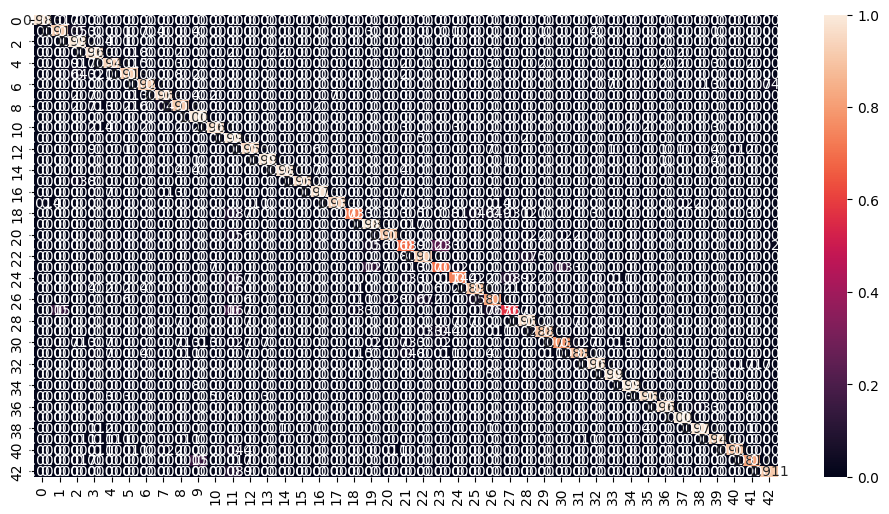

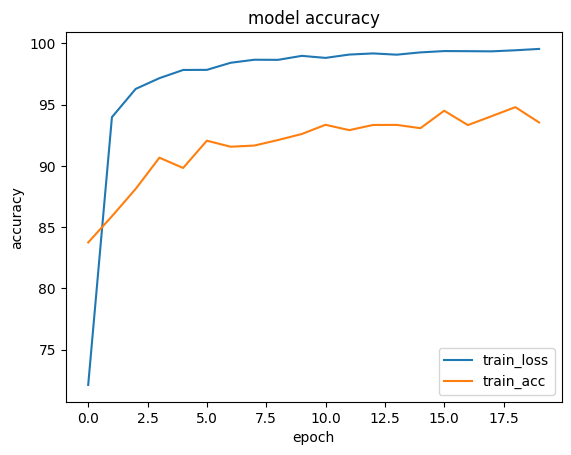

In [54]:
model = EfficientCNN(len(train_set.classes))
model.to(device)

model_info(model, train_loader, train_set, test_loader, EPOCHS, name="EfficientCNN")